# This file contains uses Household power consumption data to compare LSTM with Implicit Model

Loading Household Power Consumption dataset...


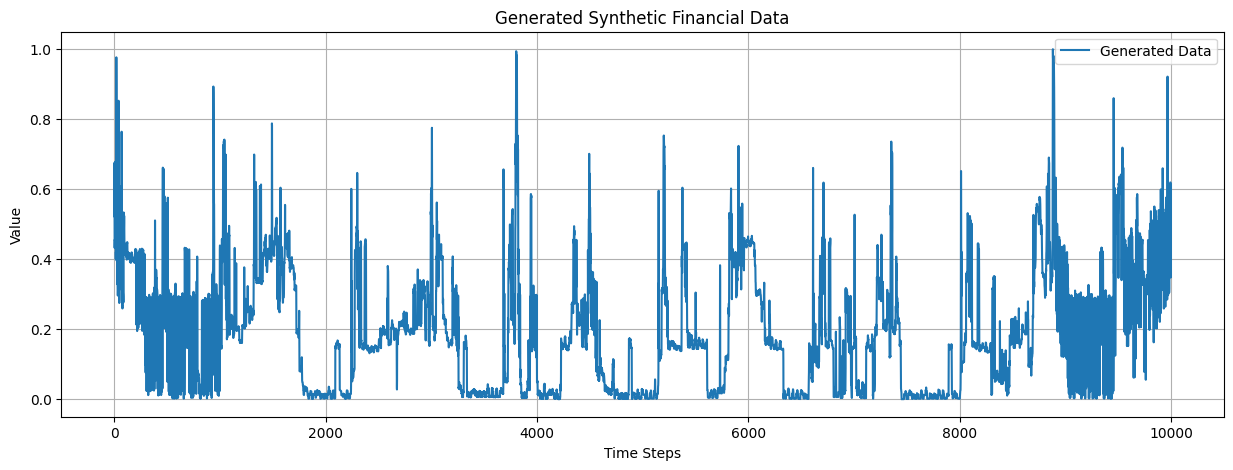

Using device: cuda

Training LSTM model...
Epoch 0, Loss: 0.375832
Epoch 10, Loss: 0.229619
Epoch 20, Loss: 0.101737
Epoch 30, Loss: 0.092126
Epoch 40, Loss: 0.078636
Epoch 50, Loss: 0.067098
Epoch 60, Loss: 0.056429
Epoch 70, Loss: 0.042314
Epoch 80, Loss: 0.030801
Epoch 90, Loss: 0.029334
Epoch 100, Loss: 0.027647
Epoch 110, Loss: 0.026492
Epoch 120, Loss: 0.025546
Epoch 130, Loss: 0.024637
Epoch 140, Loss: 0.023817

Training Implicit model...
Epoch 0, Loss: 0.349991
Epoch 10, Loss: 0.110536
Epoch 20, Loss: 0.080904
Epoch 30, Loss: 0.054867
Epoch 40, Loss: 0.043854
Epoch 50, Loss: 0.037780
Epoch 60, Loss: 0.033081
Epoch 70, Loss: 0.029391
Epoch 80, Loss: 0.026353
Epoch 90, Loss: 0.024668
Epoch 100, Loss: 0.023658
Epoch 110, Loss: 0.021664
Epoch 120, Loss: 0.020963
Epoch 130, Loss: 0.020180
Epoch 140, Loss: 0.019618

Average iterations during inference: 17.00

Results:
LSTM - R2: 0.7477, MAPE: 102976995328.0000
Implicit - R2: 0.8287, MAPE: 108347777024.0000
Implicit Model Average Iter

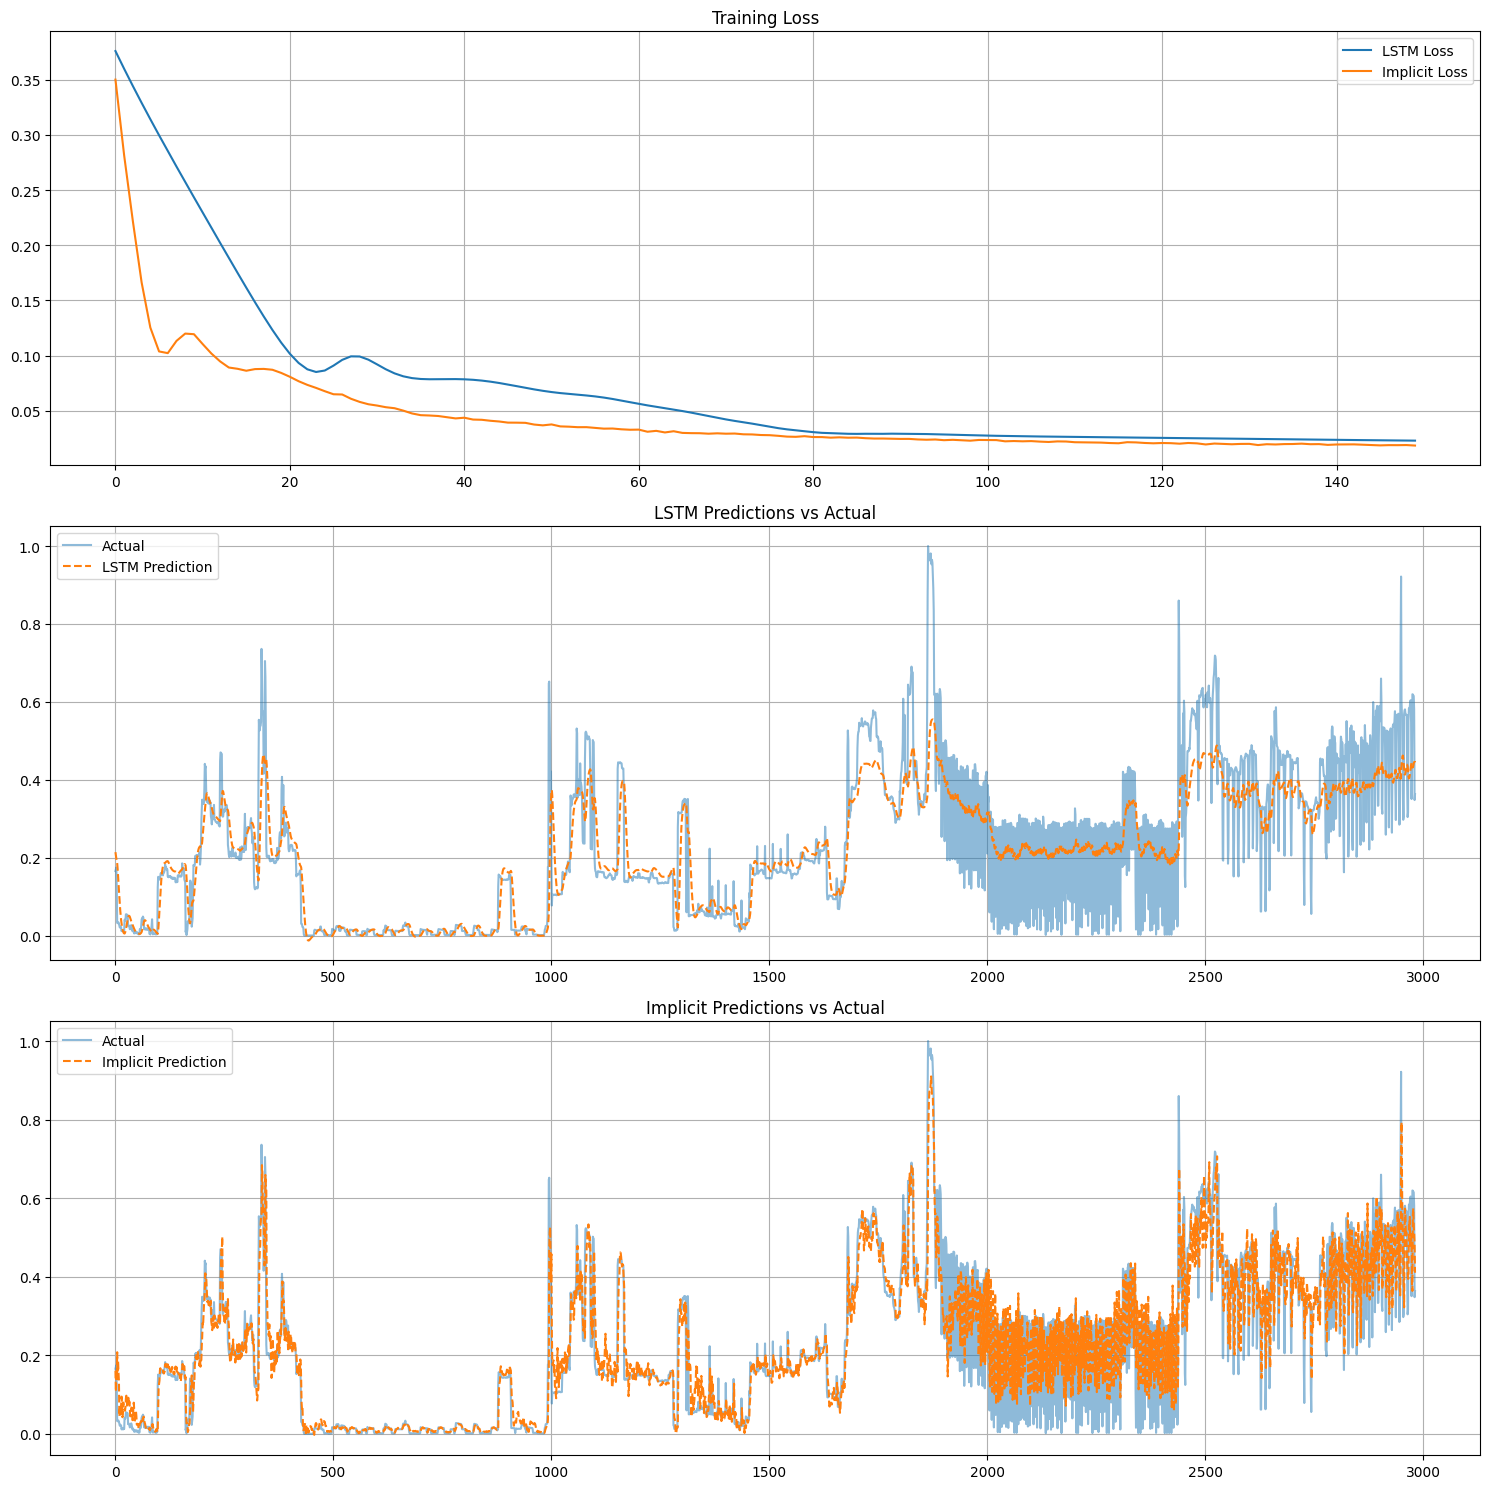

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


import pandas as pd
import numpy as np

def load_household_power_consumption(n_points=10000):
    # Download the dataset or load it if already available
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
    df = pd.read_csv(url, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'])

    # Drop NA values and select 'Global_active_power' column for simplicity
    df = df.dropna()
    data = df['Global_active_power'].values[:n_points]

    # Normalize the dataset
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
def prepare_data(data, look_back=60, train_split=0.7):
    """Prepare sequences for time series prediction"""
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back)])
        y.append(scaled_data[i + look_back])

    X = np.array(X)
    y = np.array(y)

    train_size = int(len(X) * train_split)

    # Reshape X data for LSTM: (batch_size, sequence_length, features)
    X_train_lstm = torch.FloatTensor(X[:train_size]).view(-1, look_back, 1)
    X_test_lstm = torch.FloatTensor(X[train_size:]).view(-1, look_back, 1)

    # Reshape X data for Implicit: (batch_size, features)
    X_train_implicit = torch.FloatTensor(X[:train_size]).view(-1, look_back)
    X_test_implicit = torch.FloatTensor(X[train_size:]).view(-1, look_back)

    y_train = torch.FloatTensor(y[:train_size])
    y_test = torch.FloatTensor(y[train_size:])

    return (X_train_lstm, X_train_implicit), y_train, (X_test_lstm, X_test_implicit), y_test, scaler


def train_and_evaluate(model, X_train, y_train, X_test, y_test, scaler,
                      epochs=150, lr=0.0005, batch_size=64, device="cpu", is_lstm=False):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    history = []

    # Training phase
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        if hasattr(model, 'track_iterations'):
            y_pred = model(X_train, False)  # Don't track iterations during training
        else:
            y_pred = model(X_train)

        loss = criterion(y_pred.squeeze(), y_train.squeeze())
        loss.backward()
        optimizer.step()
        history.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    # Reset iteration counter before inference if it exists
    if hasattr(model, 'reset_iteration_stats'):
        model.reset_iteration_stats()

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        # Track iterations during inference for implicit model
        if hasattr(model, 'track_iterations'):
            y_pred = model(X_test, True)  # Track iterations during inference
            avg_iterations = model.get_average_iterations()
            print(f"\nAverage iterations during inference: {avg_iterations:.2f}")
        else:
            y_pred = model(X_test)
            avg_iterations = None

        y_pred = y_pred.cpu().numpy()
        y_test = y_test.cpu().numpy()

        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

    return history, y_pred, y_test, r2, mape, avg_iterations

class ImplicitModelLoRA2(nn.Module):
    def __init__(self, lora_size, hidden_size, input_size, output_size, dropout_rate=0.1):
        super().__init__()
        self.lora_size = lora_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # Main network layers
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 2, hidden_size)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 2, hidden_size)
        )

        # LoRA layers with residual connections
        self.lora_A = nn.Sequential(
            nn.Linear(hidden_size, lora_size * 2),
            nn.ReLU(),
            nn.Linear(lora_size * 2, lora_size)
        )

        self.lora_B = nn.Sequential(
            nn.Linear(lora_size, lora_size * 2),
            nn.ReLU(),
            nn.Linear(lora_size * 2, hidden_size)
        )

        # Implicit layer
        self.implicit_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 2, hidden_size)
        )

        # Output layer
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, output_size)
        )

        self.act = nn.GELU()

        # Learnable scaling factors
        self.lora_scale = nn.Parameter(torch.tensor(0.1))
        self.implicit_scale = nn.Parameter(torch.tensor(1.0))

        # Iteration tracking
        self.total_iterations = 0
        self.inference_count = 0
        self.track_iterations = False  # Added this flag

    def forward(self, x, track_iterations=False):
        self.track_iterations = track_iterations  # Store the tracking state

        # Initial feature extraction
        h = self.fc1(x)
        h = self.act(h)

        # Residual from input processing
        residual = self.fc2(x)

        iterations = 0
        prev_h = None

        for _ in range(300):  # Max iterations
            if prev_h is not None:
                if torch.norm(h - prev_h) < 1e-5 * torch.norm(h):
                    break

            prev_h = h.clone()

            # LoRA pathway with scaled contribution
            lora_output = self.lora_B(self.lora_A(h))

            # Implicit pathway
            implicit_out = self.implicit_layer(h)

            # Combine pathways with learned scaling and residual connection
            h = self.act(
                implicit_out * self.implicit_scale +
                lora_output * self.lora_scale +
                residual
            )

            iterations += 1

        if self.track_iterations:
            self.total_iterations += iterations
            self.inference_count += 1

        # Final prediction
        out = self.fc3(h)
        return out

    def get_average_iterations(self):
        if self.inference_count == 0:
            return 0
        return self.total_iterations / self.inference_count

    def reset_iteration_stats(self):
        self.total_iterations = 0
        self.inference_count = 0
def compare_models():
    # # Generate synthetic data
    # print("Generating synthetic financial data...")
    # data = generate_complex_financial_data()

    # Load the real dataset
    print("Loading Household Power Consumption dataset...")
    data = load_household_power_consumption()

    # The rest of the code remains unchanged


    # Plot the generated data
    plt.figure(figsize=(15, 5))
    plt.plot(data, label='Consumption Data')
    plt.title('Household Power Consumption Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prepare data
    look_back = 60
    (X_train_lstm, X_train_implicit), y_train, (X_test_lstm, X_test_implicit), y_test, scaler = prepare_data(data, look_back)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Train and evaluate LSTM
    print("\nTraining LSTM model...")
    lstm_model = LSTM(
        input_dim=1,
        hidden_dim=64,
        num_layers=2,
        output_dim=1
    )
    lstm_history, lstm_pred, lstm_test, lstm_r2, lstm_mape, _ = train_and_evaluate(
        lstm_model, X_train_lstm, y_train, X_test_lstm, y_test, scaler, device=device, is_lstm=True
    )

    # Train and evaluate Implicit model
    print("\nTraining Implicit model...")
    implicit_model = ImplicitModelLoRA2(
        lora_size=2,
        hidden_size=64,
        input_size=look_back,
        output_size=1
    )
    implicit_history, implicit_pred, implicit_test, implicit_r2, implicit_mape, avg_iterations = train_and_evaluate(
        implicit_model, X_train_implicit, y_train, X_test_implicit, y_test, scaler, device=device, is_lstm=False
    )

    # Print results with iteration information
    print("\nResults:")
    print(f"LSTM - R2: {lstm_r2:.4f}, MAPE: {lstm_mape:.4f}")
    print(f"Implicit - R2: {implicit_r2:.4f}, MAPE: {implicit_mape:.4f}")
    print(f"Implicit Model Average Iterations per Inference: {avg_iterations:.2f}")


    # Plot results
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.plot(lstm_history, label='LSTM Loss')
    plt.plot(implicit_history, label='Implicit Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(lstm_test, label='Actual', alpha=0.5)
    plt.plot(lstm_pred, label='LSTM Prediction', linestyle='--')
    plt.title('LSTM Predictions vs Actual')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(implicit_test, label='Actual', alpha=0.5)
    plt.plot(implicit_pred, label='Implicit Prediction', linestyle='--')
    plt.title('Implicit Predictions vs Actual')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return data, (lstm_pred, lstm_test, lstm_r2, lstm_mape), (implicit_pred, implicit_test, implicit_r2, implicit_mape)
if __name__ == "__main__":
    data, lstm_results, implicit_results = compare_models()